<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/som_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [27]:
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler # funcion para el escalar los datos

# plots
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D


# Load Datasets

Load all the CSV files form URL and merge into a single dataframe

In [28]:
path = 'https://raw.githubusercontent.com/castudil/som-lstm/main/data/' # use your path
cities = ['chillan','curico','linares','los_angeles','osorno','puerto_montt','rancagua','san_fernando','talca'];
li = []
for i in cities:
  filename=path+i+'.csv'
  print('loading: '+filename)
  df = pd.read_csv(filename, index_col=None, header=0)
  # Convert the date column to a datestamp type
  df['date'] = pd.to_datetime(df['date'])
  # Set the date column as the index of your DataFrame meat
  df['city']=i
  df = df.set_index('date')
  #print(df.head(5))
  li.append(df)

print('consolidating into a single data frame.')
frame = pd.concat(li, axis=0, ignore_index=False)
print('displaying a random sample.')
print(frame.sample(n = 15))
print(frame.describe())
#print(frame['date'].dt.date.min()+ ' to '+ frame['date'].dt.date.max())
print(frame.index.min())
print(frame.index.max())


loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/chillan.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/curico.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/linares.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/los_angeles.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/osorno.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/puerto_montt.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/rancagua.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/san_fernando.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/talca.csv
consolidating into a single data frame.
displaying a random sample.
                       PM25          city
date                                     
2016-07-30 13:00:00  31.480  san_fernando
2018-01-02 04:00:00   8.000  san_fernando
2019-1

 

1.   The data considers nine different cities
2.   The data contains ~40K data rows
3.   No missing data
4.   PM2.5 information
5.   Data ranges from the year 2016 to 2020 









## Charts

Plot the time series for one of the cities

               PM25
count  43847.000000
mean      24.466460
std       36.239286
min        0.000000
25%        7.425000
50%       13.000000
75%       26.000000
max      555.000000


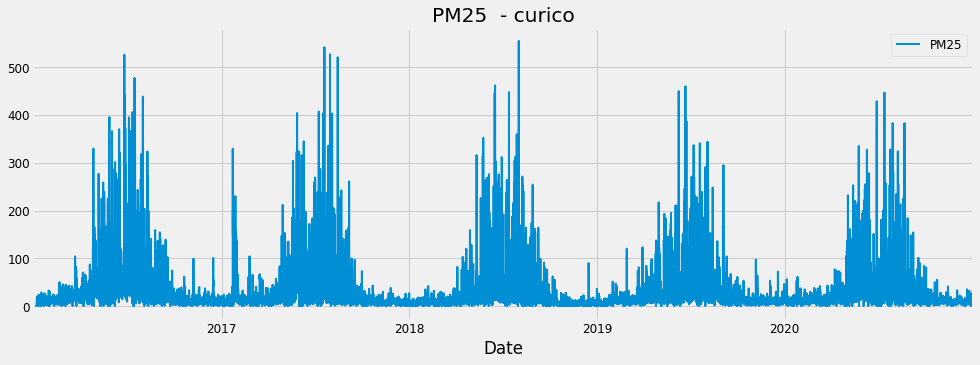

In [ ]:
def plot_city(city='curico'):
  plt.rcParams['figure.figsize'] = (15, 5)
  plt.style.use('fivethirtyeight')

  df=frame.loc[frame['city'] == city] # Sleecting Data for Curico
  print(df.describe())

  # Plot time series dataset
  ax = df.plot(linewidth=2, fontsize=12);

  # Additional customizations
  ax.set_xlabel('Date');
  ax.set_title('PM25  - ' + city)
  ax.legend(fontsize=12);
  plt.show()

plot_city('curico')

1.   Most of the peaks occur in winter, these PM25 saturation obbey to a stational nature
2.   An exception occurs in the summer of 2017, perhaps attributed to fire forest. This information is corroborated from the [newspapers](https://ambiental.net/2017/02/el-incendio-mas-destructivo-en-la-historia-reciente-de-chile/ ), mentioning that fires as one of the most devasting of the recent years and affecting the center-south of Chile.
3. we corroborate the lalter situation by analyzing the case of 2017 in nearby cities
4. we are interested in wood stove combustion
5. also wer are focused on htree months of the winter season. (check the exact dates the [paper](https://ieeexplore.ieee.org/document/9037794)
6. TODO: the data must be cut, according to the dates specified in the previous paper)
7. there is also a [youtbe video](https://www.youtube.com/watch?v=QBOnjVfikTY) with a explanation of a relataed study (in spanish)



               PM25
count  43847.000000
mean      16.653470
std       27.244984
min        0.000000
25%        3.000000
50%        8.000000
75%       19.000000
max      766.200000


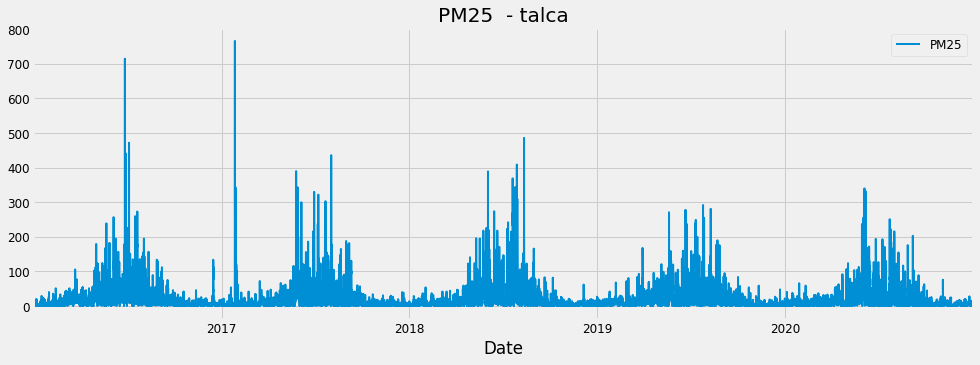

In [ ]:
plot_city('talca')

from the plot it is possible to see that the anomality was also captured in the same period of time.

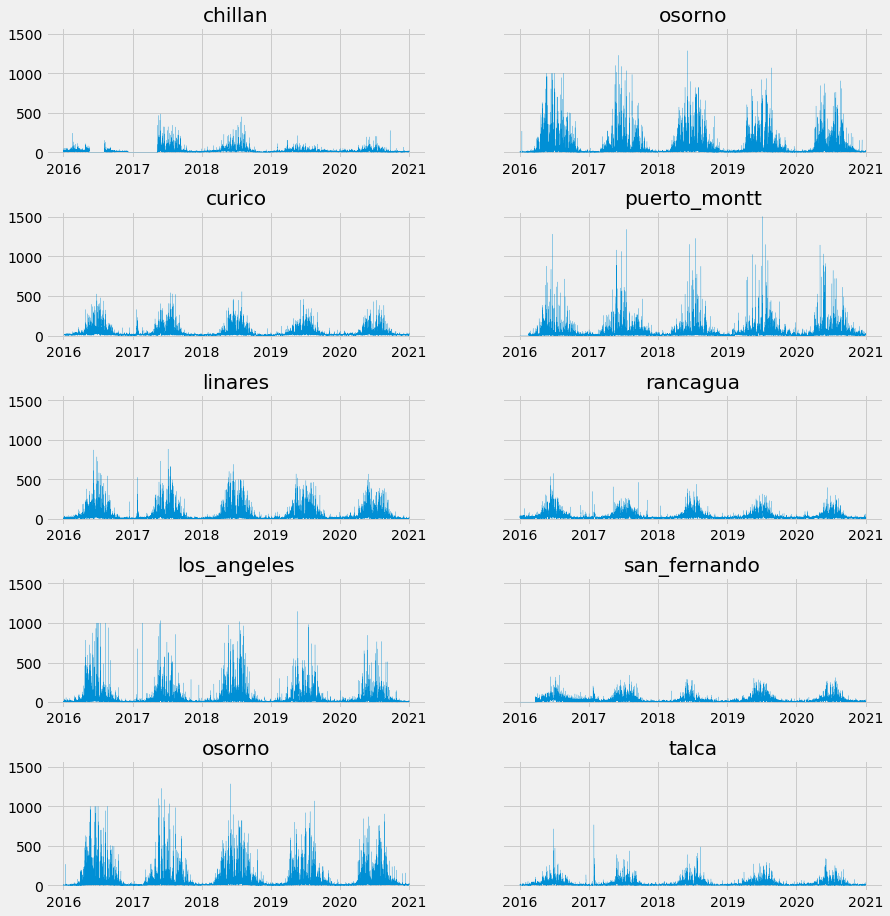

In [ ]:
df_columnCity = pd.DataFrame()

# transform cities into columns of the data frame
for city in cities:
  dfCity=frame.loc[frame['city'] == city]
  df_columnCity[city] = dfCity['PM25']#.resample('D').mean()


# initializes the subplots 
figure, axes = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(15,15),
                            sharex=False,
                            sharey=True)


#cities_graficos =['curico', 'rancagua', 'linares', 'los_angeles', 'san_fernando', 'talca']


# Draw the PM2.5 subplots for the cities. 
for i in range(5):
  axes[i, 0].plot(df_columnCity[cities[i]], linewidth=0.2)
  axes[i, 0].set_title(cities[i])
  #if(i != 4):
  axes[i, 1].plot(df_columnCity[cities[i+4]], linewidth=0.2)
  axes[i, 1].set_title(cities[i+4])


# set adjust of the subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

# show the subplots
plt.show()



In [ ]:
def columnsCityMaxToMin(df):
  serie = df.max().sort_values( ascending=False).index
  return serie

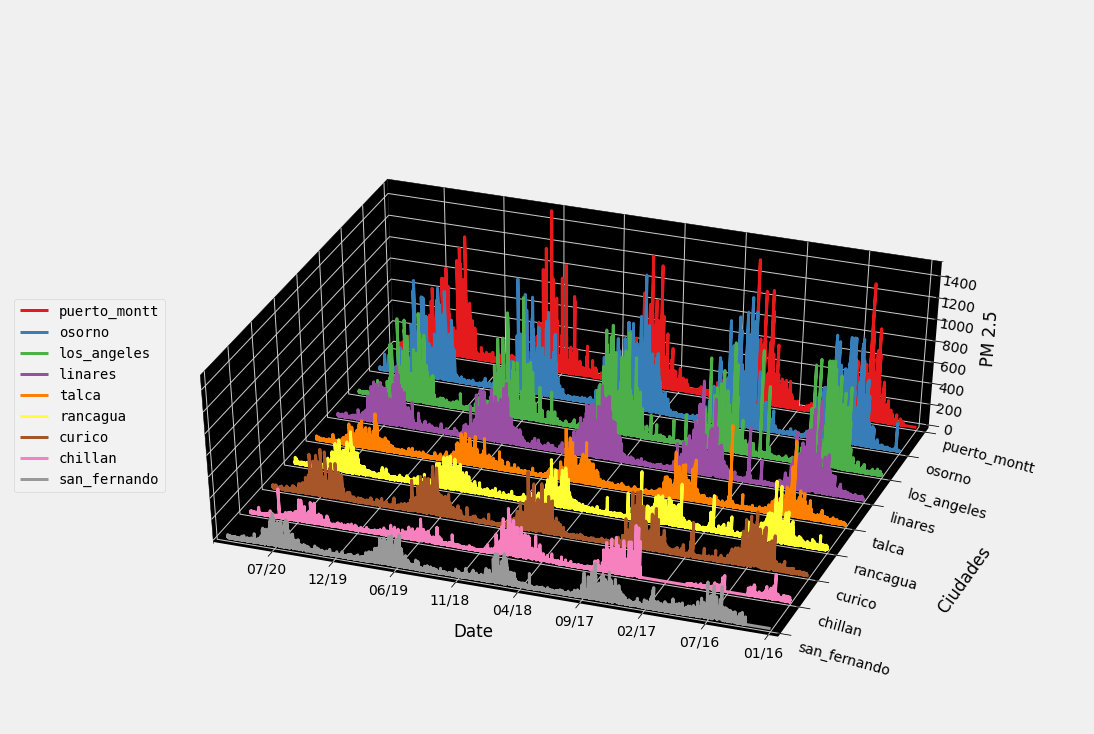

In [ ]:
# create the figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_alpha(1)

# get the cmap to use
cmap = get_cmap('Set1')

# get the slice
current_slice = df_columnCity.values[:df_columnCity.shape[0], :]
index_names = columnsCityMaxToMin(df_columnCity)
index_dates = df_columnCity.index

# for each index...
for i in range(current_slice.shape[1]):

    # get the coordinates
    x = np.array(np.arange(current_slice.shape[0]))
    y = np.tile(i, current_slice.shape[0])
    z = np.array(current_slice[:, df_columnCity.columns.to_list().index(index_names[i]) ])

    lc = Line3D(x,y,z)

    # Set the values used for colormapping
    lc.set_linewidth(3)
    lc.set_color(cmap(i))
    lc.set_label(index_names[i])
    ax.add_line(lc)

# add the grids
ax.legend(loc='center left', bbox_to_anchor=(0, 0.46), fancybox=True, facecolor=(.95,.95,.95,1), framealpha=1, shadow=False, frameon=True, ncol=1, columnspacing=0, prop={'family': 'DejaVu Sans Mono'})
ax.set_zlabel('PM 2.5', labelpad=15)
ax.set_zlim(0, 1500)
ax.set_zticklabels([int(val) for val in ax.get_zticks()],rotation=-10,)
ax.set_xlabel('Date', labelpad=30)
ax.set_xlim(0, current_slice.shape[0]-1)
ax.set_xticklabels([index_dates[int(val)].strftime('%m/%y') for val in ax.get_xticks()[:-1]] + [''], rotation=0, fontdict={'verticalalignment': 'top', 'horizontalalignment': 'center'})
ax.set_ylabel('Ciudades', labelpad=70)
ax.set_yticks(np.arange(current_slice.shape[1]))
ax.set_yticklabels([index_names[i] for i in range(current_slice.shape[1])], rotation=-15, fontdict={'verticalalignment': 'top', 'horizontalalignment': 'left'})
ax.w_xaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_yaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_zaxis.set_pane_color((0, 0, 0, 1.0))
ax.view_init(40, -250)

# ------------------------------------------------------------------
x_scale=1.8
y_scale=1.5
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0



def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
# ------------------------------------------------------------------

# show the plot
plt.show()


## Seasonality

Check the seasonality of the data

In [ ]:
  
#!pip install statsmodels


In [ ]:
from statsmodels.tsa.stattools import adfuller


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def test_stationarity(city='curico'):
  timeseries = frame.loc[frame['city'] == city] # Sleecting Data for Curico
  # #print(timeseries)

  # # Determining rolling statistics
  # rolmean = timeseries.rolling(12).mean()
  # rolstd = timeseries.rolling(12).std()

  # # Plot rolling statistics:
  # plt.rcParams['figure.figsize'] = (20, 5)
  # fig, ax = plt.subplots(figsize=(20,6))


  # orig = ax.plot(timeseries.drop(['city'], axis=1) , color='blue',label='Original', linewidth=1.5)
  # mean = ax.plot(timeseries.drop(['city'], axis=1), color='red', label='Rolling Mean',linewidth=1.5)
  # std = ax.plot(timeseries.drop(['city'], axis=1), color='black', label = 'Rolling Std' , linewidth=1.5)

  # plt.legend(loc='best')
  # plt.title('Rolling Mean & Standard Deviation')
  # plt.show(block=False)
    
  # Perform Dickey-Fuller test:
  print ('Results of Dickey-Fuller Test:')
  timeseries = timeseries.iloc[:,0].values
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

test_stationarity('curico')

Results of Dickey-Fuller Test:
Test Statistic                -1.401113e+01
p-value                        3.712124e-26
#Lags Used                     5.400000e+01
Number of Observations Used    4.379200e+04
Critical Value (1%)           -3.430499e+00
Critical Value (5%)           -2.861606e+00
Critical Value (10%)          -2.566805e+00
dtype: float64


Shorten the data set, to have only the months from April to August. 

In [ ]:

filtered_df = pd.DataFrame()
lista = []
# filter the dataset between the months of April and August from 2016 to 2020
for i in range(16,21):
  lista.append(df_columnCity.loc['20'+str(i)+'-04-1': '20'+str(i)+'-08-31'])

# consolidating into a single data frame
filtered_df = pd.concat(lista)

print(filtered_df.describe())
print(filtered_df.index.min())
print(filtered_df.index.max())




            chillan        curico  ...  san_fernando         talca
count  18360.000000  18360.000000  ...  18360.000000  18360.000000
mean      22.057152     41.742579  ...     33.286222     28.361704
std       31.171215     48.698878  ...     32.890761     35.043856
min        0.000000      0.000000  ...      0.000000      0.000000
25%        6.000000     14.840000  ...     14.000000      8.000000
50%       14.465400     26.000000  ...     24.000000     18.920000
75%       25.174125     48.000000  ...     41.000000     36.490000
max      485.000000    555.000000  ...    341.525000    714.898000

[8 rows x 9 columns]
2016-04-01 00:00:00
2020-08-31 23:00:00


## Calplot


In [ ]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year.
"""

import calendar
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
#import pandas as pd

from matplotlib.colors import ColorConverter, ListedColormap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

def yearplot(data, year=None, how='sum',
             vmin=None, vmax=None,
             cmap='viridis', fillcolor='whitesmoke',
             linewidth=1, linecolor=None, edgecolor='gray',
             daylabels=calendar.day_abbr[:], dayticks=True,
             dropzero=None,
             textformat=None, textfiller='', textcolor='black',
             monthlabels=calendar.month_abbr[1:], monthlabeloffset=15,
             monthticks=True,
             ax=None, **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    dropzero : bool
        If `True`, don't fill a color for days with a zero value.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthlabeloffset : integer
        Day offset for labels for months to adjust horizontal alignment.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    edgecolor : color
        Color of the lines that will divide months.
    textformat : string
        Text format string for grid cell text
    textfiller : string
        Fallback text for grid cell text for cells with no data
    textcolor : color
        Color of the grid cell text
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    """

    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        by_day = data.resample('D').agg(how)

    # Default to dropping zero values for a series with over 50% of rows being zero.
    if by_day[by_day == 0].count() > 0.5 * by_day.count():
        dropzero = True

    if dropzero:
        by_day = by_day.replace({0: np.nan}).dropna()

    # Min and max per day.
    if vmin is None:
        vmin = by_day.min()
    if vmax is None:
        vmax = by_day.max()

    if ax is None:
        ax = plt.gca()

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
        linecolor = ax.get_facecolor()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'

    # Filter on year.
    by_day = by_day[str(year)]

    # Add missing days.
    by_day = by_day.reindex(
        pd.date_range(start=str(year), end=str(year + 1),
                      freq='D', tz=by_day.index.tzinfo)[:-1])

    # Create data frame we can pivot later.
    by_day = pd.DataFrame({'data': by_day,
                           'fill': 1,
                           'day': by_day.index.dayofweek,
                           'week': by_day.index.isocalendar().week})

    # There may be some days assigned to previous year's last week or
    # next year's first week. We create new week numbers for them so
    # the ordering stays intact and week/day pairs unique.
    by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), 'week'] = 0
    by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), 'week'] \
        = by_day.week.max() + 1

    # Pivot data on day and week and mask NaN days.
    plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

    # Do the same for all days of the year, not just those we have data for.
    fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
    fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

    # Draw heatmap for all days of the year with fill color.
    ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))

    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, #vmax=vmax,
                  cmap=cmap, **kwargs)

    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect('equal')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_tick_params(which='both', length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []

    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []

    ax.set_xlabel('')
    ax.set_xticks([by_day.loc[pd.Timestamp(
                   datetime.date(year, i + 1, monthlabeloffset))].week
                   for i in monthticks])
    ax.set_xticklabels([monthlabels[i] for i in monthticks])

    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([6 - i + 0.5 for i in dayticks])
    ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal',
                       va='center')

    # Text in mesh grid if format is specified.
    if textformat is not None:
        for y in range(plot_data.shape[0]):
            for x in range(plot_data.shape[1]):
                content = ''
                masked = plot_data[y, x]
                if masked is np.ma.masked:
                    if fill_data[y, x] == 1:
                        content = textfiller
                else:
                    content = textformat.format(masked)
                ax.text(x + 0.5, y + 0.5, content, color=textcolor,
                         ha='center', va='center')

    # Month borders code credited to https://github.com/rougier/calendar-heatmap
    xticks = []
    start = datetime.datetime(year, 1, 1).weekday()
    for month in range(1, 13):
        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)
        y0 = 7 - first.weekday()
        y1 = 7 - last.weekday()
        x0 = (int(first.strftime('%j'))+start-1)//7
        x1 = (int(last.strftime('%j'))+start-1)//7
        P = [(x0, y0),
             (x0+1, y0),
             (x0+1, 7),
             (x1+1, 7),
             (x1+1, y1-1),
             (x1, y1-1),
             (x1, 0),
             (x0, 0) ]
        xticks.append(x0 + (x1-x0+1)/2)
        poly = Polygon(P, edgecolor=edgecolor, facecolor='None',
                       linewidth=linewidth, zorder=20, clip_on=False)
        ax.add_artist(poly)

    return ax


def calplot(data, how='sum',
            yearlabels=True, yearascending=True,
            yearlabel_kws=None, subplot_kws=None, gridspec_kws=None,
            figsize=None, fig_kws=None, colorbar=None,
            suptitle=None, suptitle_kws=None,
            tight_layout=True, **kwargs):
    """
    Plot a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    figsize : (float, float)
        Size of figure for the plot.
    suptitle : string
        Title for the plot.
    yearlabels : bool
       Whether or not to draw the year label for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `subplots` call.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `subplots` call.
    suptitle_kws : dict
        Keyword arguments passed to the matplotlib `suptitle` call.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.
    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.
    """

    if yearlabel_kws is None:
        yearlabel_kws = dict()
    if subplot_kws is None:
        subplot_kws = dict()
    if gridspec_kws is None:
        gridspec_kws = dict()
    if fig_kws is None:
        fig_kws = dict()
    if suptitle_kws is None:
        suptitle_kws = dict()

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    if colorbar is None:
        colorbar = data.nunique() > 1

    if figsize is None:
        figsize = (10+(colorbar*2.5), 1.7*len(years))

    fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,
                             figsize=figsize,
                             subplot_kw=subplot_kws,
                             gridspec_kw=gridspec_kws, **fig_kws)
    axes = axes.T[0]

    # We explicitely resample by day only once. This is an optimization.
    by_day = data
    if how is not None:
        by_day = by_day.resample('D').agg(how)

    ylabel_kws = dict(
        fontsize=30,
        color='gray',
        fontname='Helvetica',
        fontweight='bold',
        ha='center')
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    stitle_kws = dict()

    if tight_layout:
        plt.tight_layout()
        stitle_kws.update({'y': 1})

    if colorbar:
        if tight_layout:
            stitle_kws.update({'x': 0.425, 'y': 1.03})

        if len(years) == 1:
            fig.colorbar(axes[0].get_children()[1], ax=axes.ravel().tolist(),
                         orientation='vertical')
        else:
            fig.subplots_adjust(right=0.8)
            cax = fig.add_axes([0.85, 0.025, 0.02, 0.95])
            fig.colorbar(axes[0].get_children()[1], cax=cax, orientation='vertical')

    stitle_kws.update(suptitle_kws)
    plt.suptitle(suptitle, **stitle_kws)

    return fig, axes

In [ ]:
# install calplot for show calender heatmaps from pandas time series data
#!pip install calplot 


## Graph of the reduced dataset (for the winter season)

170 144.87615416666665


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


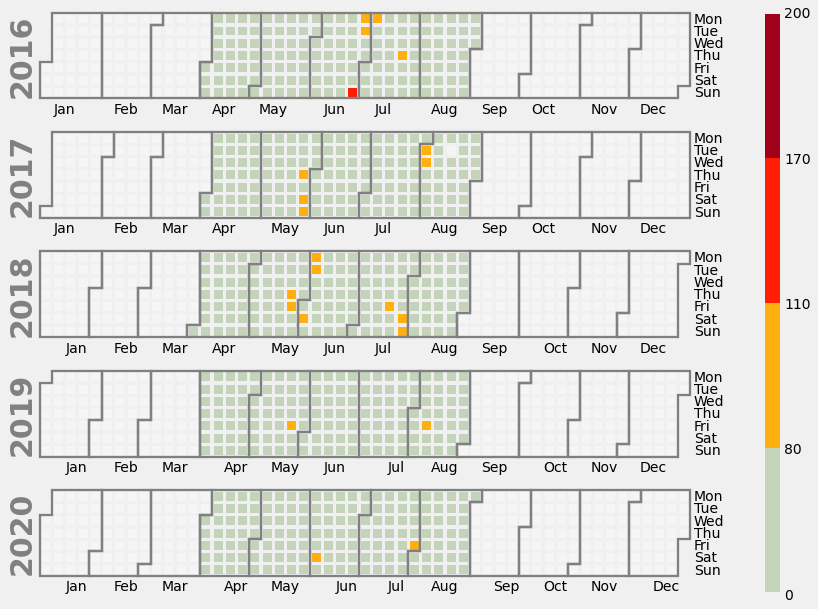

In [ ]:
#import calplot # impport calendar heatmaps from Pandas time series data

def calPlot_city(city='curico', year=""):
  # filtered for city
  df_city = filtered_df[city] 

  # calculates the average PM2.5 per day
  df_city = df_city.resample('D').mean()

  # create the colors for the color bar
  cmap = mpl.colors.LinearSegmentedColormap.from_list("",["#c4d4ba","#FFAF10","#FF1E03","#A0001A"  ])
 
  # Intervals for the color bar
  bounds = [0, 80, 110, 170, 200]

  # normalize between 0 and 1 the intervals for the color bar
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  


  print(norm(df_city.max()), df_city.max() )

  # show de calender heatmaps 
  calplot(df_city, cmap=cmap, norm=norm, linewidth=2.3, textfiller='-')


calPlot_city('talca')

- As can be seen on August 15, 2017 there was an error in the measurement or it was an anomalous day within that time period. 

170 155.16666666666666


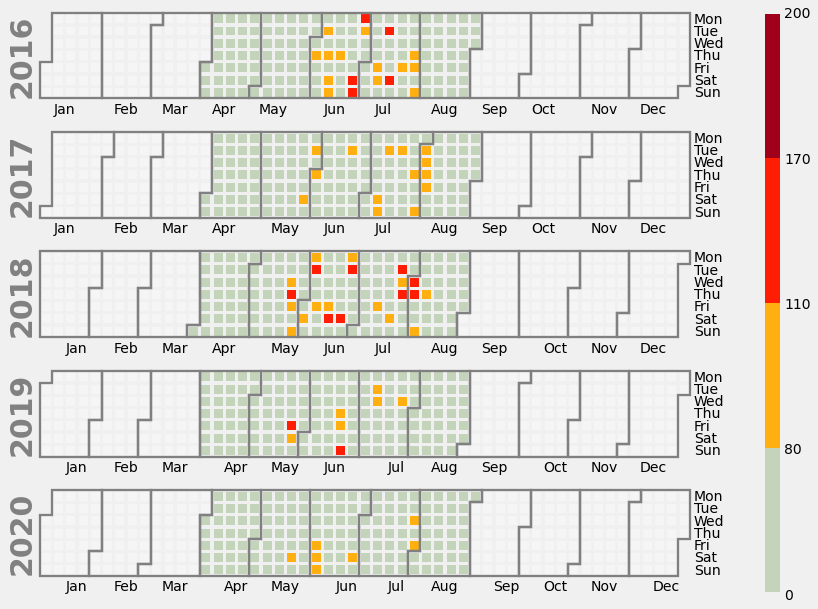

In [ ]:
calPlot_city('curico')

256 359.4166666666667


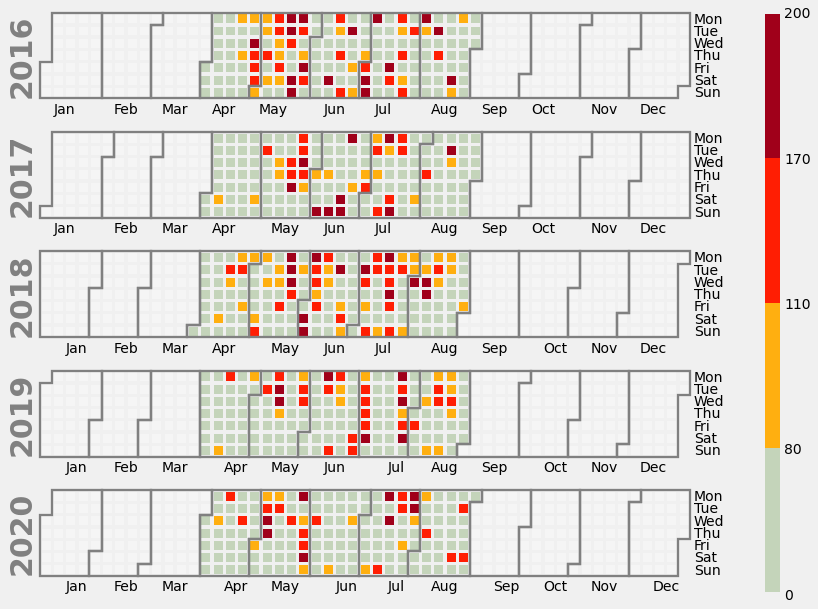

In [ ]:
calPlot_city('osorno')

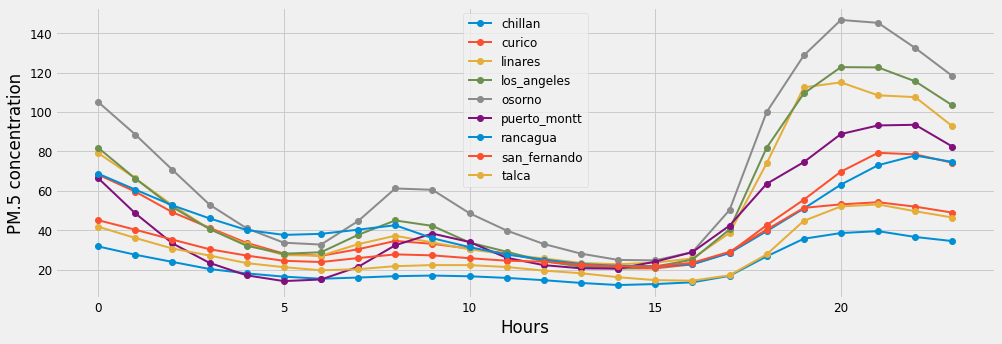

In [ ]:
def plot_mp25_hour(data):
  
  # calculates the average PM2.5 per hour
  data = data.groupby(data.index.map(lambda x: x.hour)).mean()


  # Plot average PM2.5 per hour
  ax = data.plot(linewidth=2, fontsize=12, marker='o')

  # Additional customizations
  ax.set_xlabel('Hours')
  ax.set_ylabel('PM.5 concentration')
  ax.legend(fontsize=12)
  plt.show()

plot_mp25_hour(data=filtered_df)



# Models

## Funciones

In [ ]:
def filter_data(data, start_date=2016, end_date=2020):
    """
    Función que filtra un DataFrame del tipo serie temporal con fechas como indices.
    Filtra los datos entre los meses de Abril y Agosto (Temporada de invierno). Ademas 
    de filtra entre dos años, que son dados como parámetro.

    Parameters
        -----------
    data : DataFrame
        Conjunto de datos del serie de tiempo (Importante: index del tipo Date)
    start_date : int
        año inicio
    end_date: int
        año final
    """
    filtered_df = pd.DataFrame() # copia el dataFrame 
    lista = []

    # filtra los datos entre los meses de abril y agosto, entre 2 años específicos.
    for i in range(start_date, end_date+1):
    # Obtiene los datos entre las fechas dadas.
        lista.append(data.loc[str(i)+'-04-1': +str(i)+'-08-31'])

    # consolidando los datos en un solo data frame
    filtered_df = pd.concat(lista)

    # Resumen detallado de los datos filtrados
    print(filtered_df.describe())
    print(filtered_df.index.min())
    print(filtered_df.index.max())
    return filtered_df

In [ ]:
def ts_train_test_normalize(all_data, time_steps, for_periods, name_target, start_date_train=None, end_date_train=None, start_date_test=None, end_date_test=None):
    '''
    input: 
        all_data: dataframe 
        time_steps: tamaño de la ventana para obtener una predicción
        for_periods: cantidad de datos a predecir 
        start_date_train: fecha de inicio de los datos de entramiento
        end_date_train: fecha de final de los datos de entramiento
        start_date_test: fecha de inicio de los datos de prueba
        end_date_test: fecha de final de los datos de prueba
        output:
        X_train, y_train: data de [start_date_train - end_date_train]
        X_test:  data de [start_date_test - end_date_test]
        sc:      instancia del objeto MinMaxScaler (Escala los datos de entrenamiento)
    '''


    start_date_train =  start_date_train if start_date_train else all_data.index[0]
    end_date_test =  end_date_test if end_date_test else all_data.index[len(all_data)-1]

    # crear un conjunto de entrenamiento y prueba
    ts_train = all_data[start_date_train : end_date_train].iloc[:,0:1].values
    ts_test  = all_data[start_date_test : end_date_test].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Escalar los datos en el rango (0,1)
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Crear datos de entrenamiento de s muestras y t pasos de tiempo
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        # Añade la ventana de t pasos de tiempo para el conjunto de entrenamiento x
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de entrenamiento y 
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convierte los datos de entramiento en arreglos de numpy
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reestructura X_train a 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Escala los datos para el conjunto de datos de prueba 
    inputs = pd.concat((all_data[name_target][start_date_train : end_date_train], all_data[name_target][start_date_test : end_date_test]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1) # Convertir en array cada valor del array. Ex: [1,2,3] -> [[1],[2],[3]]
    inputs  = sc.transform(inputs) # Escala los datos en el rango (0,1)

    # Crea los datos de prueba X_test de s muestras y t pasos de tiempo
    X_test, y_test = [], []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        # Añade la ventana de t pasos de tiempo para el conjunto de prueba X
        X_test.append(inputs[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de prueba y
        y_test.append(inputs[i:i+for_periods,0])
    # Convierte los datos de prueba en arreglos de numpy
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reestructura X_test a 3D [samples, timesteps, features]
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc

## Generate the datasets of train and test

In [ ]:
# filtered for city
df = frame.loc[frame['city'] == 'talca']
del(df['city'])
df.shape

(43847, 1)

In [ ]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and air quality data
    output:
      X_train, y_train: data from 2016/1/1-2019/12/31
      X_test:  data from 2020 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2019'].iloc[:,0:1].values
    ts_test  = all_data['2020':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

   
    inputs = pd.concat((all_data["PM25"][:'2019'], all_data["PM25"]['2020':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1) # Convert in array each value of array. Ex: [1,2,3] -> [[1],[2],[3]]
    inputs  = sc.transform(inputs) # Scaled the data 

    # Preparing X_test
    X_test, y_test = [], []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        y_test.append(inputs[i:i+for_periods,0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc

X_train, y_train, X_test, y_test, sc = ts_train_test_normalize(df,24,1)

print("There are " + str(X_train.shape[0]) + " samples in the training data - "+ str(X_train.shape) + " Ytrain: "+ str(y_train.shape))
print("There are " + str(X_test.shape[0]) + " samples in the test data - "+ str(X_test.shape) + " Ytrain: "+ str(y_test.shape))

There are 35038 samples in the training data - (35038, 24, 1) Ytrain: (35038, 1)
There are 8783 samples in the test data - (8783, 24, 1) Ytrain: (8783, 1)


In [31]:
def R_squared(y, y_pred):
    '''
    R_squared computes the coefficient of determination.
    It is a measure of how well the observed outcomes are replicated by the model.
    '''
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [43]:
def evaluate_model( predict):
  testY_inverse = sc.inverse_transform(y_test)

  rmse = tf.keras.metrics.RootMeanSquaredError()
  rmse.update_state(testY_inverse, predict)

  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(testY_inverse, predict)

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(testY_inverse, predict)

  from sklearn.metrics import r2_score 
  r_squared = R_squared(testY_inverse, predict)
  r2 = r2_score(testY_inverse, predict)


  #rmse_sent = math.sqrt(mean_squared_error(testY_inverse, simple_pred))
  print ("Done")
  print ('Test MSE: %.3f' %  mse.result().numpy())
  print ('Test RMSE: %.3f' % rmse.result().numpy())
  print ('Test MAE: %.3f' %  mae.result().numpy())
  print ('Test R_2: %.3f' %  r_squared.numpy())
  print ('Test R2.2: %.3f' %  r2)


In [ ]:
%matplotlib inline
plt.figure(figsize=[10, 5]); # Set dimensions for figure


def actual_pred_plot(preds):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['real', 'prediction'])
    actual_pred['real'] =   df.loc['2020':,'PM25'][0:len(preds)] #sc.inverse_transform(y_test)[:,0]
    actual_pred['prediction'] = preds[:,0]

    m = tf.keras.metrics.mean_squared_error(np.array(actual_pred['real']),np.array(actual_pred['prediction']))
    #m.update_state(np.array(actual_pred['real']),np.array(actual_pred['prediction']))
    
    return (m, actual_pred.plot())
  

<Figure size 720x360 with 0 Axes>

## Computing Some Baseline

Naive predictions (just predict the last observed value):

In [36]:
y_pred = X_test[:, -1] # Toma los valosres de t-1 
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.00024818016983482825

In [37]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, n_steps=24):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.xlim(0, n_steps + 1)
    #plt.axis([0, n_steps + 1, 0, ])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


In [44]:
evaluate_model(sc.inverse_transform(y_pred))

Done
Test MSE: 145.697
Test RMSE: 12.071
Test MAE: 4.931
Test R_2: 0.728
Test R2.2: 0.728


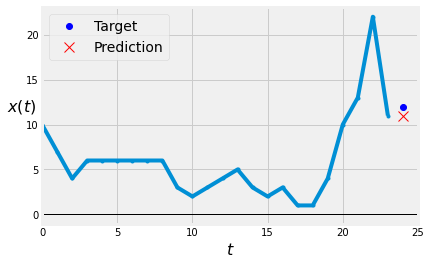

In [ ]:
plot_series(sc.inverse_transform(X_test[0, :, 0].reshape(-1,1)), sc.inverse_transform(y_test)[0, 0], sc.inverse_transform(y_pred)[0, 0])
plt.show()

## Simple RNN

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model_simple = keras.models.Sequential()

model_simple.add(keras.layers.SimpleRNN(1, input_shape=[None, 1]))

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model_simple.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])
history = model_simple.fit(X_train, y_train, epochs=20, verbose=0)
                    #validation_data=(X_valid, y_valid))
    
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_simple.evaluate(X_test, y_test)

275/275 [==============================] - 2s 5ms/step - loss: 2.2986e-04 - accuracy: 0.0098


[0.0002298640611115843, 0.009791643358767033]

In [47]:
# Finalizing predictions
simple_pred = model_simple.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
simple_pred = sc.inverse_transform(simple_pred)

In [48]:
evaluate_model(simple_pred)

Done
Test MSE: 134.945
Test RMSE: 11.617
Test MAE: 5.174
Test R_2: 0.748
Test R2.2: 0.748


(<tf.Tensor: shape=(), dtype=float32, numpy=134.94455>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb510a64b90>)

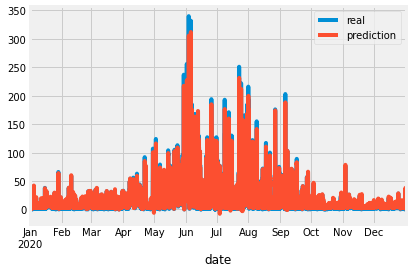

In [49]:
 actual_pred_plot(simple_pred) 

## Deep RNN

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN.compile(loss="mse", optimizer="adam",  metrics=['accuracy'])
history = model_RNN.fit(X_train, y_train, epochs=20,verbose=0)
                    #validation_data=(X_valid, y_valid))

model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_RNN.evaluate(X_test, y_test)

275/275 [==============================] - 2s 8ms/step - loss: 2.2720e-04 - accuracy: 0.0098


[0.00022720325796399266, 0.009791643358767033]

In [52]:
# Finalizing predictions
rnn_pred = model_RNN.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
rnn_pred = sc.inverse_transform(rnn_pred)

In [53]:
evaluate_model(rnn_pred)

Done
Test MSE: 133.382
Test RMSE: 11.549
Test MAE: 4.886
Test R_2: 0.751
Test R2.2: 0.751


(<tf.Tensor: shape=(), dtype=float32, numpy=133.38248>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb58a8ac210>)

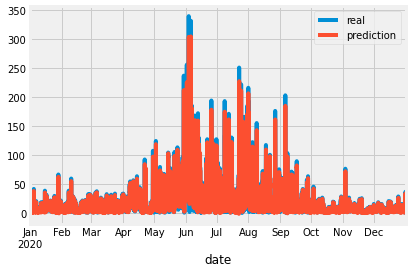

In [54]:
actual_pred_plot(rnn_pred)  

## LSTM

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model_LSTM.compile(loss="mse", optimizer="adam",  metrics=['accuracy'])
history = model_LSTM.fit(X_train, y_train, epochs=20,verbose=0)
                    #validation_data=(X_valid, Y_valid))
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_LSTM.evaluate(X_test, y_test)

275/275 [==============================] - 2s 6ms/step - loss: 2.2014e-04 - accuracy: 0.0098


[0.00022013751731719822, 0.009791643358767033]

In [57]:
# Finalizing predictions
LSTM_pred = model_LSTM.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
LSTM_pred = sc.inverse_transform(LSTM_pred)

In [58]:
evaluate_model(LSTM_pred)

Done
Test MSE: 129.234
Test RMSE: 11.368
Test MAE: 4.825
Test R_2: 0.758
Test R2.2: 0.758


(<tf.Tensor: shape=(), dtype=float32, numpy=129.23448>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb5119c8450>)

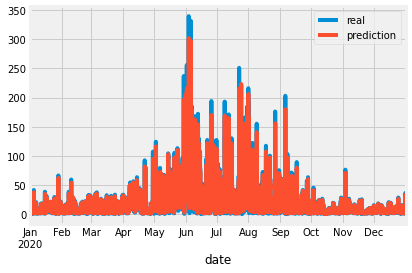

In [59]:
actual_pred_plot(LSTM_pred)  

## Deep LSTM 

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

model_Deep_LSTM = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True,),
    keras.layers.LSTM(50, return_sequences=True,),
    keras.layers.LSTM(50, return_sequences=False,),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model_Deep_LSTM.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])

history = model_Deep_LSTM.fit(X_train, y_train, epochs=20,verbose=1)
                    #validation_data=(X_valid, Y_valid))
model_Deep_LSTM.summary()

Epoch 1/20
1095/1095 [==============================] - 63s 31ms/step - loss: 5.5662e-04 - accuracy: 0.0151
Epoch 2/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.8557e-04 - accuracy: 0.0151
Epoch 3/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.7695e-04 - accuracy: 0.0151
Epoch 4/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.7976e-04 - accuracy: 0.0151
Epoch 5/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.7306e-04 - accuracy: 0.0151
Epoch 6/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.8165e-04 - accuracy: 0.0151
Epoch 7/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.7163e-04 - accuracy: 0.0151
Epoch 8/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.5000e-04 - accuracy: 0.0151
Epoch 9/20
1095/1095 [==============================] - 34s 31ms/step - loss: 3.6109e-04 - accuracy: 0.0151
Epoch 10/20
1095/1095 [=====

In [64]:
model_Deep_LSTM.evaluate(X_test, y_test)

275/275 [==============================] - 5s 12ms/step - loss: 2.2559e-04 - accuracy: 0.0098


[0.00022558991622645408, 0.009791643358767033]

In [65]:
# Finalizing predictions
Deep_LSTM_pred = model_Deep_LSTM.predict(X_test)
#from sklearn.preprocessing import MinMaxScaler
Deep_LSTM_pred = sc.inverse_transform(Deep_LSTM_pred)

In [66]:
evaluate_model(Deep_LSTM_pred)

Done
Test MSE: 132.435
Test RMSE: 11.508
Test MAE: 5.074
Test R_2: 0.752
Test R2.2: 0.752


(<tf.Tensor: shape=(), dtype=float32, numpy=132.43535>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb50fb13050>)

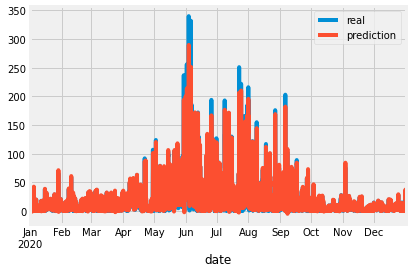

In [67]:
actual_pred_plot(Deep_LSTM_pred)  